In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from math import ceil, floor
from tqdm.auto import tqdm
import os

sns.set_style('whitegrid')
max_rows = pd.get_option('display.max_rows')
max_cols = pd.get_option('display.max_columns')

In [10]:
# set path information
data_path = r'../data-eda'
models_path = r''
oly_fname = r'olympics_summer_features.csv'

# load data and keep a raw copy
oly_raw = pd.read_csv(os.path.join(data_path, oly_fname))
oly = oly_raw.copy()
print(f"Total Rows, Cols: {oly.shape}")
oly_raw.head()

Total Rows, Cols: (2996, 49)


,games,country,alpha_3,ioc_code,host,year,gold,silver,bronze,total,...,games_silver,games_bronze,games_medals,n_teams,medals_per_team,past_tot_1,past_tot_2,past_tot_3,past_tot_4,past_tot_5
0,Athens 1896,Australia,AUS,AUS,0,1896,2,0,0,2,...,43,36,122,16,7.625,NaN,NaN,NaN,NaN,NaN
1,Athens 1896,Austria,AUT,AUT,0,1896,2,1,2,5,...,43,36,122,16,7.625,NaN,NaN,NaN,NaN,NaN
2,Athens 1896,Bulgaria,BGR,BUL,0,1896,0,0,0,0,...,43,36,122,16,7.625,NaN,NaN,NaN,NaN,NaN
3,Athens 1896,Chile,CHL,CHI,0,1896,0,0,0,0,...,43,36,122,16,7.625,NaN,NaN,NaN,NaN,NaN
4,Athens 1896,Denmark,DNK,DEN,0,1896,1,2,3,6,...,43,36,122,16,7.625,NaN,NaN,NaN,NaN,NaN


## Select features
Propose using the following features:
- **Population from 20 years before.** The hypothesis being this is approx median age that olympians qualify for the Games
- **GDP per capita from 4 years before.** While it likely takes longer than 4 years to make an olympian, funding cycles for sports and athletes are every olympics.
- **Host nation.** There is an objective home advantage for hosting (easier qualification, choosing favourite sports, practicing at actual venues etc)
- **Medals per team.** While this doesn't fluctuate massively, it normalises the scarecity of medals for the model

In [11]:
target = 'total'
features = ['pop_20', 'gdppc_4', 'host_0', 'medals_per_team',]
tgt_feat = [target]
tgt_feat.extend(features)
tgt_feat

['total', 'pop_20', 'gdppc_4', 'host_0', 'medals_per_team']

The decision is made to use data from 1980 onwards. It feels most representative of the 'modern games'. Also, while doping has been a challenge for years, the geopolitics around

In [12]:
# Only model using data from 1988 onwards
oly = oly[oly.year>=1988]
oly.shape

(1754, 49)

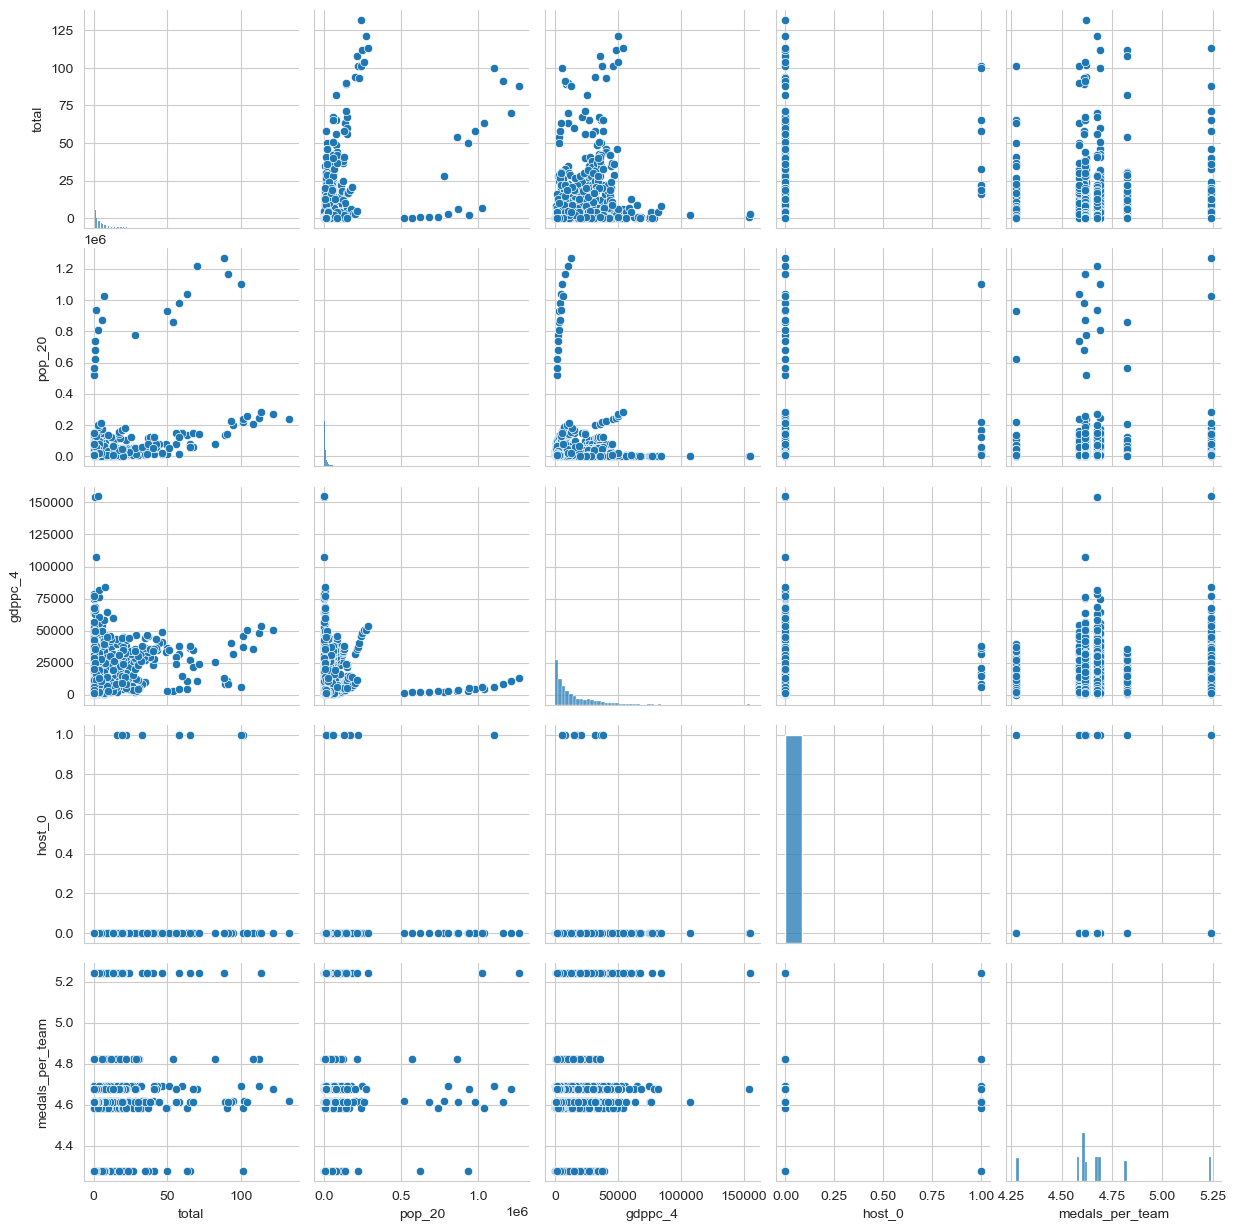

In [13]:
sns.pairplot(data=oly, vars=tgt_feat)

### Drop NaNs
Blank features need to be dropped before modelling. The decision has been made not to impute here.

/var/folders/8q/g320q7wx097bzc5_wmy6p0tm0000gn/T/ipykernel_33314/3228075752.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mask1 = data=oly.isna().replace({True: 0, False: 1})
/var/folders/8q/g320q7wx097bzc5_wmy6p0tm0000gn/T/ipykernel_33314/3228075752.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mask2 = data=oly.isna().replace({True: 0, False: 1})


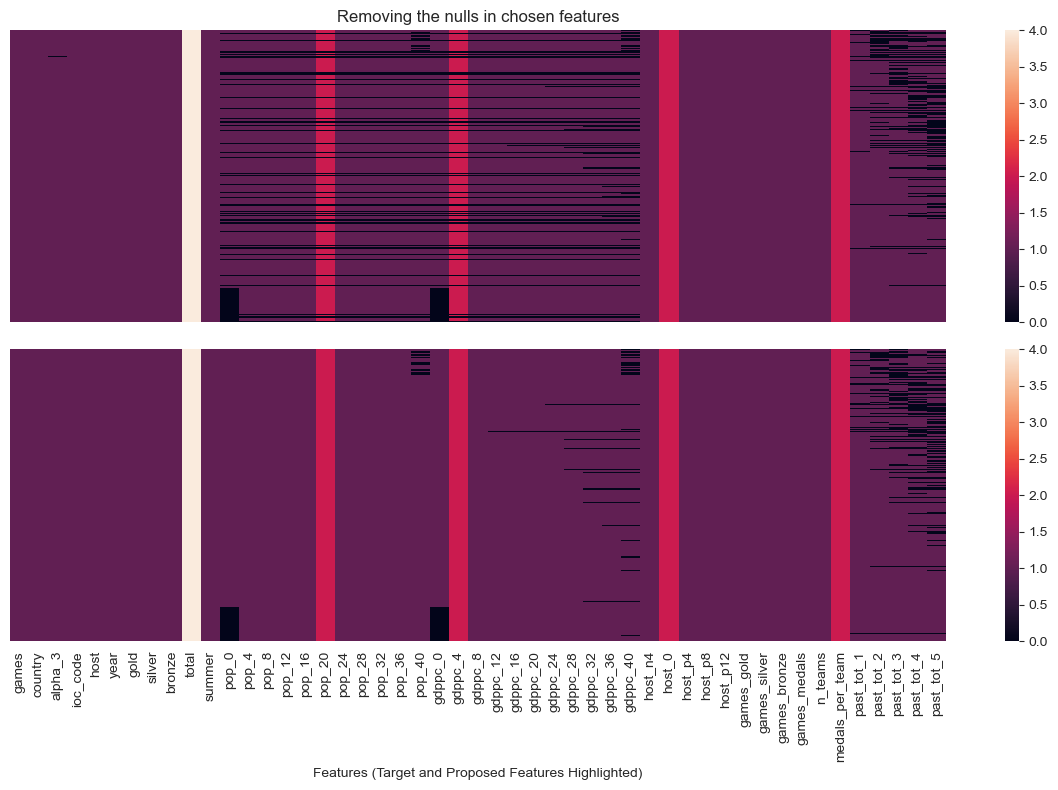

In [ ]:
# initialise figure
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# prepare mask for the plots (indicating features and target before/after)
mask1 = data=oly.isna().replace({True: 0, False: 1})
mask1[features] = mask1[features] * 2
mask1[target] = mask1[target] * 4

# drop NAs only for the proposed features
oly = oly.dropna(subset=tgt_feat)

# new mask for the cleaned data
mask2 = data=oly.isna().replace({True: 0, False: 1})
mask2[features] = mask2[features] * 2
mask2[target] = mask2[target] * 4

# plot the heatmaps
sns.heatmap(mask1, ax=ax[0])
sns.heatmap(mask2, ax=ax[1])

# clean-up, label, save the plot
ax[0].set_yticklabels([])
ax[0].set_title('Removing the nulls in chosen features')
ax[1].set_yticklabels([])
plt.xlabel('Features (Target and Proposed Features Highlighted)')
plt.tight_layout()
plt.savefig('../images/mod-dropna.png')
plt.show()

In [15]:
oly.shape

(1416, 49)

## Modelling Setup
Load packages and prepare the data for training.

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
# Patch the class to avoid the warning
XGBRegressor.__sklearn_tags__ = lambda self: {}

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.model_selection import train_test_split, cross_val_score, KFold, RepeatedKFold, RandomizedSearchCV, GridSearchCV

from sklearn.inspection import permutation_importance

from skopt.space import Integer, Real, Categorical
from skopt.utils import use_named_args
from skopt.callbacks import VerboseCallback, DeltaYStopper
from skopt import BayesSearchCV

Set default values for training and experiment setup.

In [17]:
error_score = 'neg_root_mean_squared_error' # MSE used to penalise larger errors more
# error_score = 'neg_mean_absolute_error'
test_size = 0.25
random_seed = 0
k_fold = KFold(n_splits=10, shuffle=True, random_state=random_seed)
k_fold_repeat = RepeatedKFold(n_splits=10, n_repeats=3, random_state=random_seed)

results = []

Split strategy. There are two main options:
1. split across all samples, meaning that nations have a mix of train and test
2. split between nations, meaning each nation is either train or test

On balance option 1 is preferable. While patterns between years will leak into test predictions, actually this is relevant to the real-world predictions as some nations really are consistently better (history). Furthermore there are only c.1400 records in total, and splitting by nation would lead to poor generalisation.

In reality I'll use cross-validation to evaluate the model anyway so the split here is less critical.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(oly[features],
                                                    oly[target],
                                                    test_size=test_size,
                                                    random_state=random_seed)

In [19]:
oly['test'] = 0
oly.loc[y_test.index,'test'] = 1
oly[['games', 'country'] + features + [target, 'test']].head()

/var/folders/8q/g320q7wx097bzc5_wmy6p0tm0000gn/T/ipykernel_33314/2898403250.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oly['test'] = 0


,games,country,pop_20,gdppc_4,host_0,medals_per_team,total,test
1242,Seoul 1988,Afghanistan,11825.0,1337.0,0,4.61875,0,0
1243,Seoul 1988,Algeria,13146.0,5361.0,0,4.61875,0,1
1246,Seoul 1988,Angola,5350.0,1259.0,0,4.61875,0,1
1248,Seoul 1988,Argentina,23261.0,11837.0,0,4.61875,2,0
1250,Seoul 1988,Australia,12102.0,24009.0,0,4.61875,14,1


### Utility functions

In [73]:
def train_test_error(model, X_train, y_train, X_test, y_test, scoring='neg_mean_absolute_error'):
    '''Calculate error score for train and test sets to help identify overfitting'''
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    if scoring=='neg_mean_absolute_error':
        err_train = mean_absolute_error(y_pred=y_pred_train, y_true=y_train)
        err_test = mean_absolute_error(y_pred=y_pred_test, y_true=y_test)
    elif scoring=='neg_root_mean_squared_error':
        err_train = np.sqrt(mean_squared_error(y_pred=y_pred_train, y_true=y_train))
        err_test = np.sqrt(mean_squared_error(y_pred=y_pred_test, y_true=y_test))
    
    return err_train, err_test

def scores_to_df(scores, params, var_name, score_name='mae'):
    '''Convert list of cross-val score arrays into dataframe for plotting in seaborn'''
    s = {}
    for i, param in enumerate(params):
        try:
            param = round(param, 3)
        except:
            pass
        s[str(param)] = np.absolute(scores[i])
    s = pd.DataFrame(s).melt(var_name=var_name, value_name=score_name)
    return s


def scores_to_df(scores, params, var_name, score_name='mae'):
    '''Convert list of cross-val score arrays into dataframe for plotting in seaborn'''
    s = {}
    for i, param in enumerate(params):
        try:
            param = round(param, 3)
        except:
            pass
        s[str(param)] = np.absolute(scores[i])
    s = pd.DataFrame(s).melt(var_name=var_name, value_name=score_name)
    return s


def model_fit_plot(model, X_train, y_train, X_test, y_test, bias_adjust=1, save_file=None):
    ''' Function that produces a scatter plot for train and test data '''
    
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # draw plots
    plt.scatter(model.predict(X_train) * bias_adjust, y_train)
    plt.scatter(model.predict(X_test) * bias_adjust, y_test)
    
    # label axes
    plt.xlabel('Prediction')
    plt.ylabel('True Values')
    
    # scale axes
    lim = max(y_train.max(), y_test.max()) * 1.05
    plt.xlim([0, lim])
    plt.ylim([0, lim])
    
    # annotate
    plt.title(f'{model.__class__.__name__}: Train vs Test Predictions')
    plt.legend(['Train', 'Test'])

    # save if required
    plt.tight_layout()
    if save_file is not None:
        plt.savefig(save_file)
    plt.show()


def plot_true_pred(oly, ioc_codes, model_name_col, width=2, save_file=None):
    '''Function that plots a grid of subplots for both true and predicted data, highlighting test data'''
    
    # initialise plots
    height = ceil(len(ioc_codes)/width)
    fig, ax = plt.subplots(height, width, figsize=(10, int(height*1.1+10)), sharex=True)
    ax = [item for sublist in ax for item in sublist]
    lines = []

    # iterate through countries
    with pd.option_context('mode.chained_assignment', None):
        for i, ioc_code in enumerate(tqdm(ioc_codes)):
            # filter data
            df = oly.loc[oly.ioc_code==ioc_code, ['games', 'country', 'ioc_code', 'year', 'total', 'test', model_name_col]]

            # draw plots
            lines.append(sns.lineplot(data=df, x='year', y='total', ax=ax[i], label='True'))
            lines.append(sns.lineplot(data=df, x='year', y=model_name_col, ax=ax[i], label='Predict'))
            lines.append(sns.scatterplot(data=df[df.test==1], x='year', y=model_name_col, ax=ax[i], label='Test Set'))
            
            # get legend handles and labels
            handles, labels = plt.gca().get_legend_handles_labels()

            # Keep only specific legend labels
            keep_labels = ['True', 'Predict', 'Test Set']
            new_handles = [handle for handle, label in zip(handles, labels) if label in keep_labels]
            new_labels = [label for label in labels if label in keep_labels]

            # show legend only on first axes
            plt.legend(new_handles, new_labels)
            if i != 0:
                ax[i].get_legend().remove()
            
            # clean and finish labelling plots
            # _ = ax[i].set_xticklabels(oly[oly.ioc_code==ioc_code].games.unique(), rotation=45, ha='right')
            title = f'{model_name_col} Predictions: {oly[oly.ioc_code==ioc_code].country.unique()[0]} '
            title = title + f'({oly[oly.ioc_code==ioc_code].ioc_code.unique()[0]})'
            ax[i].set_xticks(df.year.sort_values().unique())
            ax[i].set_title(title)
        
        # Ensure plot axes fit in figure when saving
        plt.tight_layout()

        # save file if filename/path is defined
        if save_file is not None:
            plt.savefig(save_file)
        plt.show()

## Training and XGBoost Model
XGBoost is known as a powerful model. We don't have lots of data, so need to be careful not to overfit. However, there are c.1200 total records (c.900 training) so with just 4 features there should be enough to train a robust model with regularisation.

First, spot-check the model with its default settings.

### Spot-Check Model

XGBRegressor, CV: RepeatedKFold(n_repeats=3, n_splits=10, random_state=0)
neg_root_mean_squared_error: -8.798
Train: 0.7864607977028174
Test: 8.579848599718208


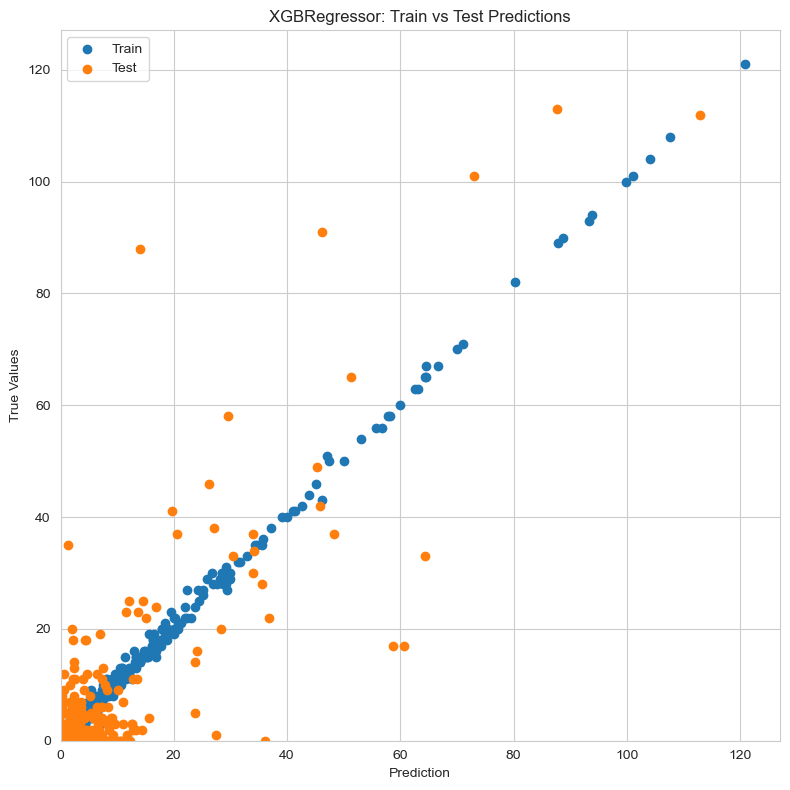

In [77]:
# initialise and set-up model
# xgb = make_pipeline(StandardScaler(), XGBRegressor(random_state=random_seed))
xgb = XGBRegressor(random_state=random_seed)
model_name = xgb.__class__.__name__
cv = k_fold_repeat
xgb_cv = np.mean(cross_val_score(xgb, X_train, y_train, cv=cv, n_jobs=-1, scoring=error_score))

# fit model
xgb.fit(X_train, y_train)
y_pred_test = xgb.predict(X_test)
y_pred_train = xgb.predict(X_train)

# calc metrics & print results
xgb_initial_err_train, xgb_initial_err_test = train_test_error(xgb, X_train, y_train, X_test, y_test, scoring=error_score)

print((f'{model_name}, CV: {cv}\n'
       f'{error_score}: {np.mean(xgb_cv):.3f}\n'
       f'Train: {xgb_initial_err_train}\nTest: {xgb_initial_err_test}'))

# plot results
save_file = '../images/mod-untuned-perf.png'
model_fit_plot(xgb, X_train, y_train, X_test, y_test, save_file=save_file)

The model massively overfit with its default values!

### Hyperparameter Tuning
Experiment with scikit-optimize to find the best settings.

Iteration No: 1 started. Searching for the next optimal point.
Iteration No: 1 ended. Search finished for the next optimal point.
Time taken: 0.1579
Function value obtained: 9.0046
Current minimum: 9.0046
Iteration No: 2 started. Searching for the next optimal point.
Iteration No: 2 ended. Search finished for the next optimal point.
Time taken: 0.1237
Function value obtained: 12.1142
Current minimum: 9.0046
Iteration No: 3 started. Searching for the next optimal point.
Iteration No: 3 ended. Search finished for the next optimal point.
Time taken: 0.0749
Function value obtained: 11.9230
Current minimum: 9.0046
Iteration No: 4 started. Searching for the next optimal point.
Iteration No: 4 ended. Search finished for the next optimal point.
Time taken: 0.0748
Function value obtained: 10.6967
Current minimum: 9.0046
Iteration No: 5 started. Searching for the next optimal point.
Iteration No: 5 ended. Search finished for the next optimal point.
Time taken: 0.0752
Function value obtained: 10.

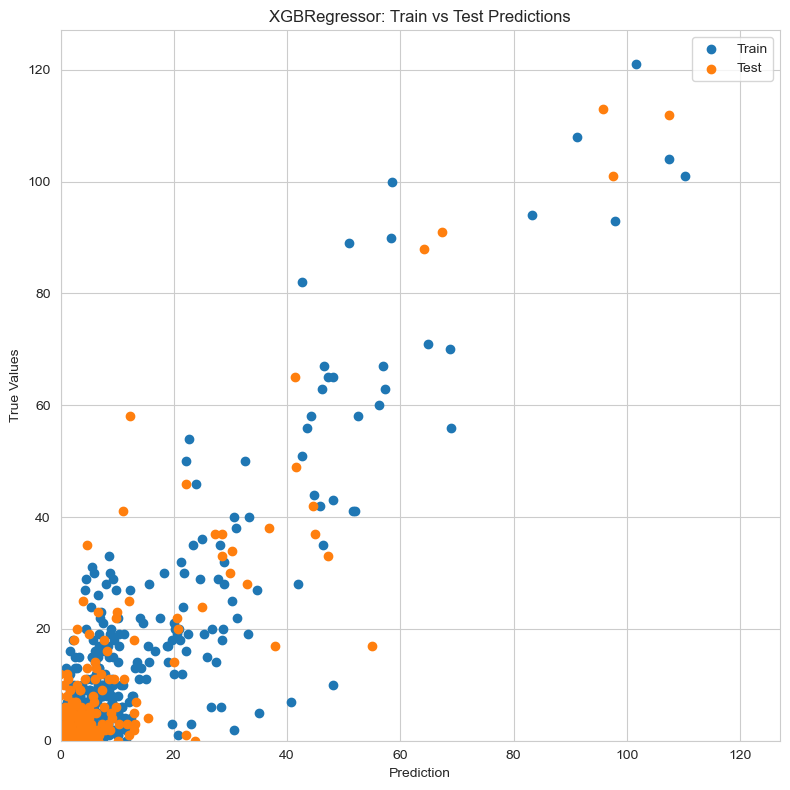

In [75]:
# initiate model
xgb_tune = XGBRegressor(max_depth=6,
                        min_child_weight=6,
                        subsample=1.,
                        colsample_bytree=1.,
                        gamma=2.6,
                        reg_alpha=11.4,
                        reg_lambda=5.8,
                        learning_rate=0.0026,
                        n_estimators=1400,
                        random_state=random_seed)

# set search parameters
# search_spaces = {'max_depth': (2, 20),
#                  'min_child_weight': (1.0, 20.0, 'uniform')}
search_spaces = {'learning_rate': (.001, 1., 'log-uniform'), 
                 'n_estimators': (50, 1500),
                 'max_depth': (2, 20),
                 'subsample': (0.6, 1.0),
                 'colsample_bytree': (0.3, 1.0),
                 'reg_alpha': (0, 5),
                 'reg_lambda': (.1, 10)}

# initialise tuner
cv = k_fold
tuner_man = BayesSearchCV(estimator=xgb_tune,
                          search_spaces=search_spaces,
                          scoring=error_score,
                          n_iter=100,
                          cv=cv,
                          n_jobs=-1,
                          verbose=0,
                          random_state=random_seed)

# fit tuner
t1 = time.time()
tuner_man.fit(X=X_train,
              y=y_train,
              callback=[VerboseCallback(n_total=50), DeltaYStopper(n_best=5, delta=0.02)])
# DeltaYStopper(n_best=5, delta=0.05)

# print results
xgb_tune_best = tuner_man.best_estimator_
xgb_tune_err_train, xgb_tune_err_test = train_test_error(xgb_tune_best, X_train, y_train, X_test, y_test, scoring=error_score)
print(f'\nSearch Time: {time.strftime("%H:%M:%S", time.gmtime(time.time()-t1))}')
print((f'Initial Cross Val Score ({cv}):\t{xgb_cv:.3f}\n'
       f'Tuned Cross Val Score ({cv}):\t{tuner_man.best_score_:.3f}\n'
       f'Initial Error:\tTrain: {xgb_initial_err_train:.3f}\tTest: {xgb_initial_err_test:.3f}\n'
       f'Tuned Error:\tTrain: {xgb_tune_err_train:.3f}\tTest: {xgb_tune_err_test:.3f}\n'))
print(tuner_man.best_params_)

# plot train/test predictions vs labels and save
save_file = '../images/mod-tuned-perf.png'
model_fit_plot(xgb_tune_best, X_train, y_train, X_test, y_test, save_file=save_file)

The model has slightly over-fitted, but not by too much, and much less than the initial values.

In [27]:
xgb_tune_best.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 1.0,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 2.6,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.02376823696609466,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 2,
 'max_leaves': None,
 'min_child_weight': 6,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 1500,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 0,
 'reg_alpha': 5,
 'reg_lambda': 10.0,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 0.6,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

### Save the Model

In [80]:
from datetime import datetime
import joblib

# get datestring
today_date = datetime.today().strftime('%y%m%d')

# save file
model_filename = f'{today_date}-oly_tuned_xgboost_regressor.pkl'
joblib.dump(xgb_tune_best, model_filename)

['250202-oly_tuned_xgboost_regressor.pkl']

### Load the Model

In [81]:
model_load_filename = model_filename # change if needed in future
model = joblib.load(model_load_filename)
model_name = model.__class__.__name__

# Predicting the Medal Tabel for the Olympic Games
This is a regression problem: predicting the numerical number of medals won by a nation at a particular Olympic Games based on openly available informaiton.

### Feature Importance
**Permutation Importance:** This approach is more reliable for high cardinality features but is slower to compute. But in 2025 with this data that's not really a factor...

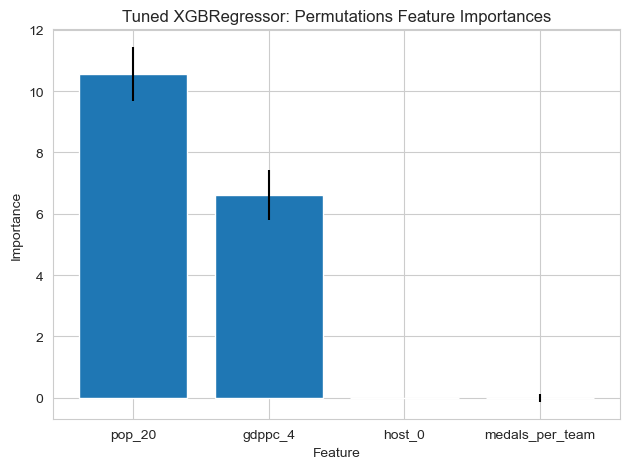

In [82]:
result = permutation_importance(model, 
                                X_test, 
                                y_test, 
                                n_repeats=10, 
                                scoring=error_score,
                                random_state=random_seed, 
                                n_jobs=-1)
plt.bar(features, result.importances_mean, yerr=result.importances_std)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title(f'Tuned {model_name}: Permutations Feature Importances')
plt.tight_layout()
plt.savefig('../images/mod-feature-importance.png')

Population is the most powerful predictor using this method, followed by GDP per capita. It seems that host nation in particular and medals per team have very little impact on the model.

### Predictions vs Data
Now we can apply the model to different nations' data and see how well it performs. It is applied to train and test values, with test records being highlighted.

In [83]:
# store results
model_name_col = model_name
oly[model_name_col] = model.predict(oly[features])
oly[model_name_col] = oly[model_name_col].astype('int')
oly.head()

/var/folders/8q/g320q7wx097bzc5_wmy6p0tm0000gn/T/ipykernel_33314/1196207904.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oly[model_name_col] = model.predict(oly[features])
/var/folders/8q/g320q7wx097bzc5_wmy6p0tm0000gn/T/ipykernel_33314/1196207904.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oly[model_name_col] = oly[model_name_col].astype('int')


,games,country,alpha_3,ioc_code,host,year,gold,silver,bronze,total,...,games_medals,n_teams,medals_per_team,past_tot_1,past_tot_2,past_tot_3,past_tot_4,past_tot_5,test,XGBRegressor
1242,Seoul 1988,Afghanistan,AFG,AFG,0,1988,0,0,0,0,...,739,160,4.61875,NaN,0.0,NaN,0.0,0.0,0,0
1243,Seoul 1988,Algeria,DZA,ALG,0,1988,0,0,0,0,...,739,160,4.61875,2.0,0.0,NaN,0.0,0.0,1,3
1246,Seoul 1988,Angola,AGO,ANG,0,1988,0,0,0,0,...,739,160,4.61875,NaN,0.0,NaN,NaN,NaN,1,0
1248,Seoul 1988,Argentina,ARG,ARG,0,1988,0,1,1,2,...,739,160,4.61875,0.0,NaN,0.0,1.0,2.0,0,4
1250,Seoul 1988,Australia,AUS,AUS,0,1988,3,6,5,14,...,739,160,4.61875,24.0,9.0,5.0,17.0,17.0,1,6


100%|██████████| 168/168 [00:17<00:00,  9.34it/s]


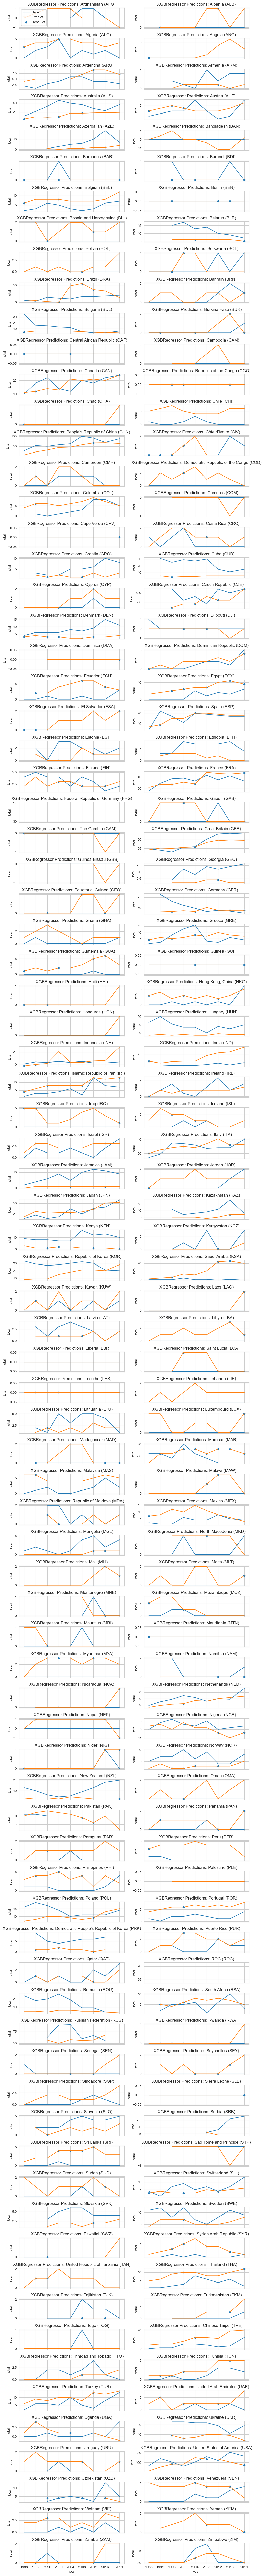

In [63]:
ioc_codes = [a3 for a3 in oly.ioc_code.sort_values().unique()]

# plot grid of predictions vs results
plot_true_pred(oly=oly,
               ioc_codes=ioc_codes,
               model_name_col=model_name,
               width=2,
               save_file=None)

100%|██████████| 8/8 [00:00<00:00, 54.38it/s]


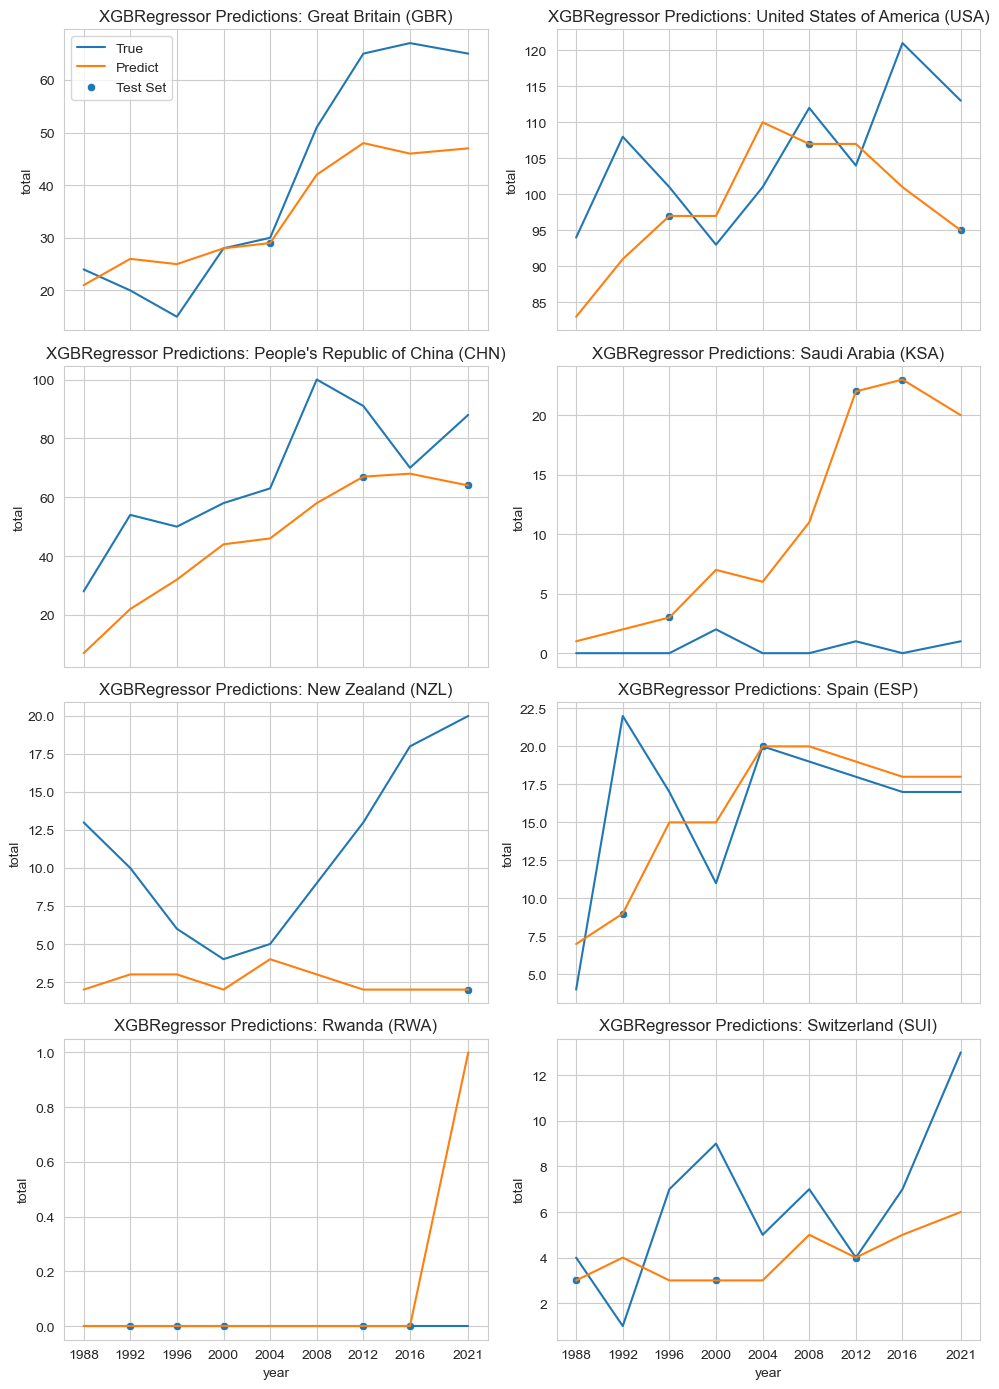

In [85]:
# plot a subset of nations for more detailed analysis and saving
ioc_codes = ['GBR', 'USA', 'CHN', 'KSA', 'NZL', 'ESP', 'RWA', 'SUI']
save_file = r'../images/mod-preds.png'

# plot grid of predictions vs results
plot_true_pred(oly=oly,
               ioc_codes=ioc_codes,
               model_name_col=model_name,
               width=2,
               save_file=save_file)